## Predicting CO2 levels for Mauna Loa

**Author: Thodoris Petropoulos**

### Scope
The scope of this Notebook is to provide an end to end example of how to use Out of Time Validation (OTV) when working with DataRobot using the Python API. 


### Background

OTV is important when we assume or know that the data we have change distribution over time in which case random sampling of training and testing datasets would not yield an outcome that would be representative of our accuracy in deployment time.

OTV can be applied in both classification and regression projects. In essence, OTV will partition your data using the Backtesting method like in Time Series modeling. 

The data can be accessed [here](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html) and they represent monthly CO2 levels of one of Hawaii's active volcanoes, Mauna Loa. Note that we could have used this dataset to do Time Series modeling, but for the purposes of demonstrating OTV, we are not.

Furthermore, we will be using `interpolated` as our target outcome since `average` has a few missing values which we would like to skip.


### Requirements

- Python version 3.7.3
- DataRobot API version 2.21.0. Small adjustments might be needed depending on the Python version and DataRobot API version you are using.


Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com

#### Import Libraries
To start with, lets import the libraries that will be used in this tutorial

In [1]:
import pandas as pd
import datarobot as dr

import seaborn as sns
import matplotlib.pyplot as plt

/Users/thodoris.petropoulos/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Import Dataset

In [2]:
df = pd.read_csv('data/co2_mm_mlo.csv')
df['day'] = 1 #Arbitrary day column to create a correct date feature type
df.head()

,year,month,decimal date,average,interpolated,trend,ndays,day
0,1958,3,1958.208,315.71,315.71,314.62,-1,1
1,1958,4,1958.292,317.45,317.45,315.29,-1,1
2,1958,5,1958.375,317.50,317.50,314.71,-1,1
3,1958,6,1958.458,-99.99,317.10,314.85,-1,1
4,1958,7,1958.542,315.86,315.86,314.98,-1,1


#### Connect to DataRobot

Connect to DataRobot using your api token and your endpoint. Change input below accordingly.

In [3]:
dr.Client(token ='YOUR_TOKEN' ,
          endpoint ='YOUR_ENDPOINT')

#### Preprocessing
We need to do the following:

- Create single column with Date.
- Remove unneeded features
- Create 4-month lag features.

Note that we could have created far more features (such as aggregates on a monthly level or even percentages), but for the purposes of OTV, this is not needed.

In [4]:
df['date'] = pd.to_datetime(df[['year', 'month','day']])
df.drop(['year','month', 'decimal date', 'average', 'ndays'],inplace=True, axis=1)

#Create 2 month lag features
for i in range(1,5):
    df['lag_{}'.format(i)] = df['interpolated'].shift(i)
    
df = df.iloc[8:]
df.head()

,interpolated,trend,day,date,lag_1,lag_2,lag_3,lag_4
8,313.33,315.31,1,1958-11-01,312.66,313.20,314.93,315.86
9,314.67,315.61,1,1958-12-01,313.33,312.66,313.20,314.93
10,315.62,315.70,1,1959-01-01,314.67,313.33,312.66,313.20
11,316.38,315.88,1,1959-02-01,315.62,314.67,313.33,312.66
12,316.71,315.62,1,1959-03-01,316.38,315.62,314.67,313.33


#### Plotting and investigating our data
It becomes very obvious from this plot that the data is following an upwards trend. Randomly partitioning our data for testing purposes would not work and we would not get representative accuracy metrics.

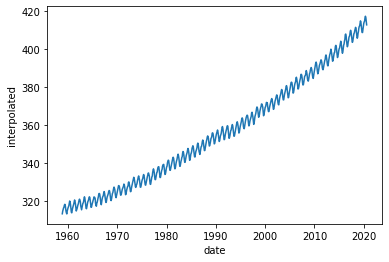

In [5]:
sns.lineplot(x='date', y='interpolated',data=df)

#### Define Datetime Partitioning

For more options and a more complete example of Datetime Partitioning, check [here](https://github.com/datarobot-community/examples-for-data-scientists/blob/master/Advanced%20Tuning%20and%20Partitioning/Python/Datetime%20Partitioning.ipynb)

In [6]:
spec = dr.DatetimePartitioningSpecification(datetime_partition_column = 'date',
                                            number_of_backtests = 4,
                                            use_time_series = False)

#### Start Project
I will be passing the `spec` object as an input to the `partitioning_method` variable in the `set_target` method. This will start the project with my designated settings.

In [ ]:
project = dr.Project.create(df, project_name = 'Predicting CO2 levels for Mauna Loa')

project.set_target('average',partitioning_method = spec, worker_count=-1)
project.wait_for_autopilot()

#### Getting access to insights
As always, all insights are available using both the API and the UI. Below we have an example of getting Feature Impact from one of the trained models.

For more examples and sample code for extracting insights, check [here]( https://github.com/datarobot-community/examples-for-data-scientists/tree/master/Model%20Evaluation/Python)

In [ ]:
model = project.get_models()[0]

#Get Feature Impact
feature_impact = model.get_or_request_feature_impact()

#Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

#Plot feature impact
sns.barplot(x='featureName', y='impactNormalized', data=fi_df[0:5], color='g')